# Image Input & Image Output

In [1]:
import cv2 as cv
import math
import time
from cv2 import imshow

- It first takes the image and goes through a face detection system. <br> <br>

- Now there is a function called `getFaceBox()` it is just opening that is just reading through the `opencv_face_detector_uint8.pb` file right here and getting the dimensions or the direct or the location of the face in the image and it takes that information and supplies it to the gender and age detection module. <br> <br>

- So what is happening right here, there are basically three steps:

    - one is reading the image and passing it to the face detectors the face is detected and there's a small pre-processing stage the next stage is the pre-processing stage where you're doing some sort of processing on the image and once that is done then you're sending it to the detector module which is going to detect the age and gender of the person so what are these three steps one is simply doing the face reduction. <br> <br>
    
    

In [2]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

- The second is pre-processing now what is this preprocessing that is a function called as `blobFromImage()` and what this function does is, it tries to bring your image. The image that you have on your file that you want to test it tries to bring that image onto the same level same property as the original image where this the model was trained.<br> So the researchers or the people who deployed or made these models they went through they shipped through different types of images which they themselves collected and they had their own database those images are completely different they had a different brightness they had a different profile they were on it they were taken on a different day different saturation different person so those images had a different property level.<br> By using `blobFromImage()` frame image we are going to bring our image to that same property level so it basically takes an image and removes all the variables all the extraneous information like the brightness the saturation the hue all these things that define an image it takes it out and it brings the image to its base bare minimum that bare minimum information of that image so it removes all the external features from the image and it brings down to the bare minimum the big bones that as we say and uses that image for our detection and you know it sends it to the age and gender detection not the original image so that's what the `blobFromImage()` does for us and it just brings that image into that basic property so that when you send it to the gender or the age detection model it will give you the right output without much error. <br> <br>

In [3]:
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"


MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

- So coming down here once we define all the functions we just use the simple three line snippet to read an image send it to the agent detector function and give us the output right here.

In [4]:
from PIL import Image
# from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np

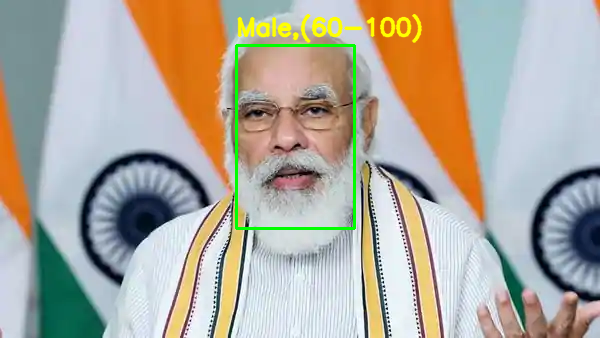

In [5]:
inputImg = cv.imread("sample_test_images/narendra_modi.jpg")
outputImg = age_gender_detector(inputImg)

# print output image in actual size
outputImg = cv.cvtColor(outputImg, cv.COLOR_BGR2RGB)
outputImg=Image.fromarray(outputImg)
outputImg

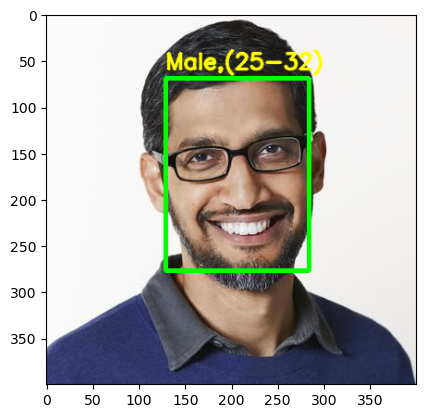

In [6]:
inputImg = cv.imread("sample_test_images/Sundar_Pichai.jpg")
outputImg = age_gender_detector(inputImg)

# print output image in comapct size
outputImg = cv.cvtColor(outputImg, cv.COLOR_BGR2RGB)
plt.imshow(outputImg)
plt.show()

# Video Input & Video Output

In [7]:
import cv2
cap = cv2.VideoCapture('sample_test_images/suhani_video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Done processing video
